# loading things

In [1]:
from rl_environment import Rl_env,Rl_env_multiple, read_and_prepare_data
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rcParams['figure.dpi']=200

In [2]:
def make_simple_dataset(how_many,rl_env,prediction_variable='Close'):
    x = []
    y = []
    y_inv_trans = []
    indexes = []
    for i in range(how_many):
        indexes.append(rl_env.current_index()[0])
        x.append(rl_env.state.to_numpy())
        next_day = rl_env.get_next_day()  
        y.append(next_day[prediction_variable].iloc[0])
        y_inv_trans.append(rl_env.scale_data(next_day,inverse_transform=True)[prediction_variable].iloc[0])

        rl_env.step_period()

    new_dataset = pd.DataFrame(columns=['x','y','y_inv_trans','index'])


    
    new_dataset['x'].astype(object)
    new_dataset['x'] = x
    new_dataset['y'] = y
    new_dataset['y_inv_trans'] = y_inv_trans
    new_dataset['index']=indexes
    new_dataset.index = pd.to_datetime(new_dataset['index'])

    new_dataset.set_index('index',inplace=True,drop=True)
    rl_env.reset_state()

    return new_dataset

Nan found in dataset, removed rows 1
loaded 1201 rows and 1 columns from code 1301
loaded columns:['Close']


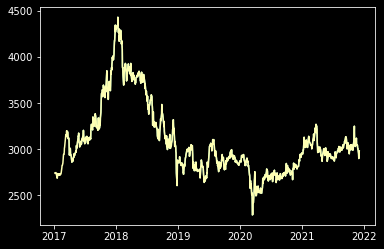

In [3]:
period_length=50
rl_env=Rl_env(1301,period_length=period_length,scaler = StandardScaler(),columns=['Open','Close','Volume','Low','High'])
num_points = rl_env.full_dataset.shape[0]-rl_env.period_length

new_dataset = make_simple_dataset(num_points,rl_env)

plt.figure()
plt.plot(new_dataset['y_inv_trans'])
plt.plot(rl_env.full_dataset['Close'])


In [4]:
rl_env.full_dataset.isnull().values.any()

False

# tf example

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
num_inputs = period_length
num_actions = 3
num_hidden = 128


inputs = layers.Input(shape=(num_inputs,1))
common = layers.LSTM(num_hidden)(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

2022-06-11 14:11:28.921920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

gamma = 0.99
eps = np.finfo(np.float32).eps.item() 

# histories = {'actions':[],'rewards':[],'action_probs':[]}

while True:  # Run until solved
    rl_env.reset_state()
    state = rl_env.state
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(0, num_points-2*period_length):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])
            # Sample action from action probability distribution

            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            # histories['actions'].append(action)
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            reward = rl_env.get_reward(action)
            rl_env.step_period()
            state = rl_env.state
            
            rewards_history.append(reward)
            episode_reward += reward

        
        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )
        

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # histories['action_probs'].append(action_probs_history.copy())
        # histories['rewards'].append(rewards_history.copy())
        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
    
    # Log details
    episode_count += 1
    
    print(f"episode: {episode_count}, running reward: {running_reward:.3f}, episode_reward: {episode_reward:.3f}")
    

    if running_reward > 1:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break
    


running reward: 0.014, episode_reward: 0.287 at episode 1
running reward: 0.012, episode_reward: -0.033 at episode 2
running reward: 0.006, episode_reward: -0.108 at episode 3
running reward: 0.006, episode_reward: -0.003 at episode 4
running reward: 0.009, episode_reward: 0.078 at episode 5
running reward: -0.009, episode_reward: -0.359 at episode 6
running reward: 0.000, episode_reward: 0.180 at episode 7
running reward: 0.001, episode_reward: 0.013 at episode 8
running reward: 0.006, episode_reward: 0.107 at episode 9
running reward: 0.010, episode_reward: 0.076 at episode 10
running reward: 0.026, episode_reward: 0.346 at episode 11
running reward: 0.010, episode_reward: -0.294 at episode 12
running reward: -0.013, episode_reward: -0.455 at episode 13
running reward: -0.016, episode_reward: -0.066 at episode 14
running reward: -0.002, episode_reward: 0.256 at episode 15
running reward: -0.017, episode_reward: -0.307 at episode 16
running reward: -0.018, episode_reward: -0.033 at ep

KeyboardInterrupt: 

In [8]:
# model.save('models/first_try')

INFO:tensorflow:Assets written to: models/first_try/assets


INFO:tensorflow:Assets written to: models/first_try/assets


In [14]:
rl_env.reset_state()
new_dataset = make_simple_dataset(num_points,rl_env)
actions = []
action_probs_list = []

for state in new_dataset['x']:
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    action_probs, critic = model(state)
    action_probs_list.append(action_probs)
    actions.append(np.argmax(action_probs))

new_dataset['actions']=actions
    

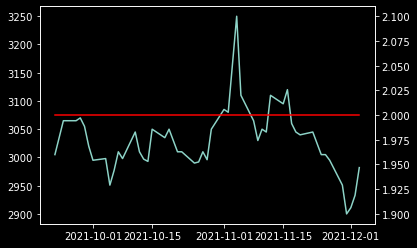

In [10]:
fig,ax=plt.subplots()
ax.plot(new_dataset['y_inv_trans'].iloc[-50:])
ax2=ax.twinx()
ax2.plot(new_dataset['actions'].iloc[-50:],c='r')

In [12]:
np.unique(actions)

array([2])

In [23]:
a=[]
for ac in action_probs_list:
    a.append(np.squeeze(ac.numpy()))
a = np.array(a)

In [25]:
a.mean(axis=0)

array([0.05655271, 0.11817338, 0.8252735 ], dtype=float32)

# portfolio management

In [2]:
sec_codes = [1301,1332,1333,9997,9994]
columns=['Close']
test = read_and_prepare_data(sec_codes,columns)
test

Nan found in dataset for sec code [1301, 1332, 1333, 9997, 9994], removed 1 rows


,1301,1332,1333,9997,9994
Date,,,,,
2017-01-04,2742.0,571.0,3210.0,778.0,1754.0
2017-01-05,2738.0,568.0,3250.0,802.0,1767.0
2017-01-06,2740.0,575.0,3270.0,808.0,1765.0
2017-01-10,2748.0,562.0,3235.0,804.0,1750.0
2017-01-11,2745.0,553.0,3185.0,799.0,1750.0
...,...,...,...,...,...
2021-11-29,2951.0,567.0,2269.0,668.0,2358.0
2021-11-30,2900.0,573.0,2277.0,667.0,2328.0
2021-12-01,2911.0,574.0,2299.0,685.0,2340.0


Nan found in dataset for sec code [1301, 1332, 1333, 9997, 9994], removed 1 rows
loaded 1201 rows from codes [1301, 1332, 1333, 9997, 9994]


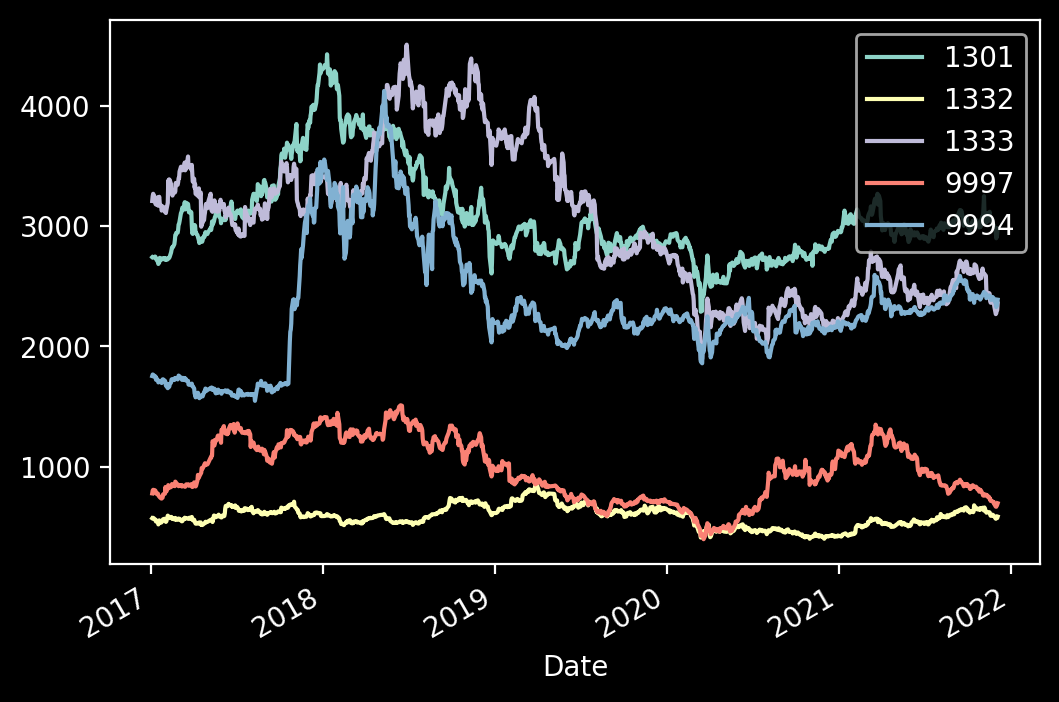

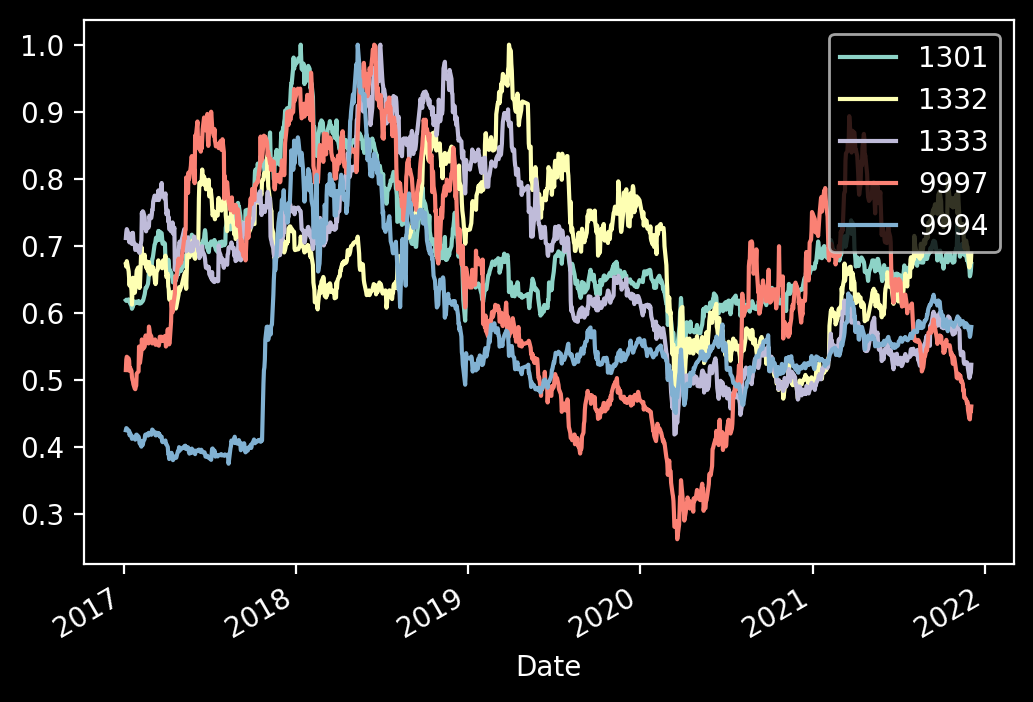

In [3]:
period_length = 50
rl_env_multiple = Rl_env_multiple(sec_codes,MaxAbsScaler(),period_length,columns,scale_everything=True)
num_points = rl_env_multiple.full_dataset.shape[0]-period_length

In [4]:
rewards = []
rl_env_multiple.reset_state()
for i in range(1000):
    rewards.append(rl_env_multiple.get_reward_and_set_distribution(distribution=np.ones(5)/5))
    rl_env_multiple.step_period()
    # print(rl_env_multiple.state.iloc[-1])

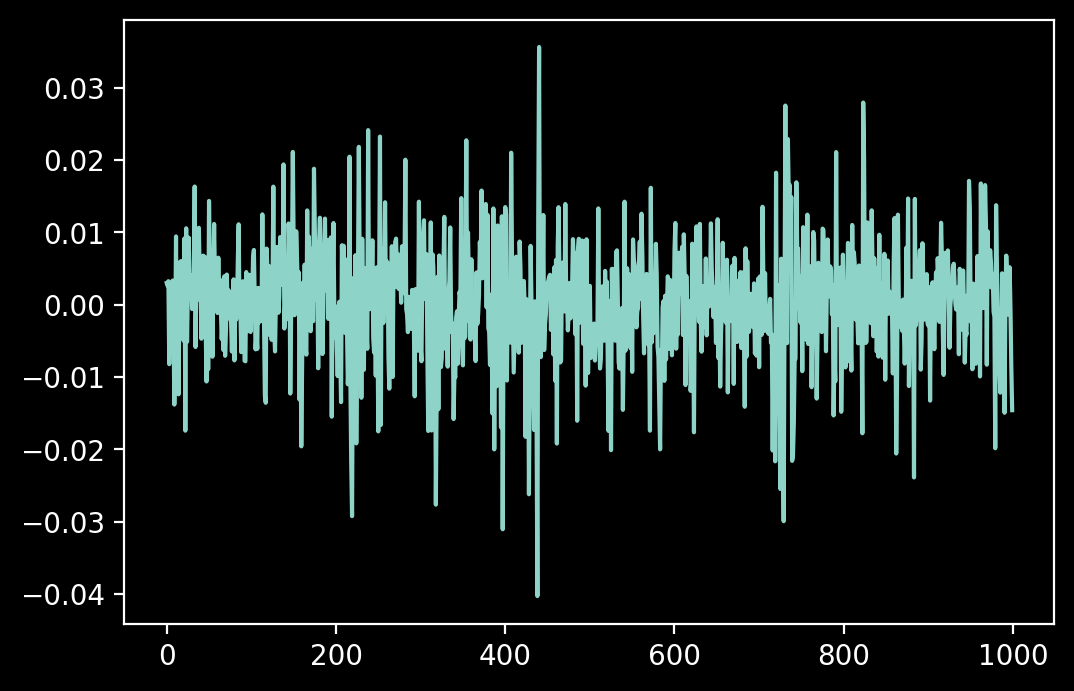

In [5]:
plt.plot(rewards)

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
num_inputs = period_length
num_features = 5
num_hidden = 128


inputs = layers.Input(shape=(num_inputs,num_features))
common = layers.LSTM(num_hidden)(inputs)
action = layers.Dense(num_features, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

2022-06-13 21:31:08.173358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

gamma = 0.99
eps = np.finfo(np.float32).eps.item() 

# histories = {'actions':[],'rewards':[],'action_probs':[]}

while True:  # Run until solved
    rl_env_multiple.reset_state()
    state = rl_env_multiple.state
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(0, num_points):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])
            # Sample action from action probability distribution

            action = np.random.choice(num_features, p=np.squeeze(action_probs))
            # histories['actions'].append(action)
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            reward = rl_env_multiple.get_reward_and_set_distribution(np.squeeze(action_probs.numpy()))
            rl_env_multiple.step_period()
            state = rl_env_multiple.state
            
            rewards_history.append(reward)
            episode_reward += reward

        
        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )
        

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # histories['action_probs'].append(action_probs_history.copy())
        # histories['rewards'].append(rewards_history.copy())
        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
    
    # Log details
    episode_count += 1
    
    print(f"episode: {episode_count}, running reward: {running_reward:.3f}, episode_reward: {episode_reward:.3f}")
    

    if running_reward > 1:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break
    


episode: 1, running reward: -0.001, episode_reward: -0.028
episode: 2, running reward: -0.002, episode_reward: -0.022
episode: 3, running reward: -0.003, episode_reward: -0.016
episode: 4, running reward: -0.003, episode_reward: -0.011
episode: 5, running reward: -0.003, episode_reward: 0.005
episode: 6, running reward: -0.002, episode_reward: 0.009
episode: 7, running reward: -0.002, episode_reward: 0.011
episode: 8, running reward: -0.001, episode_reward: 0.011
episode: 9, running reward: -0.001, episode_reward: 0.010
episode: 10, running reward: -0.000, episode_reward: 0.008
episode: 11, running reward: 0.000, episode_reward: 0.006
episode: 12, running reward: 0.000, episode_reward: 0.005
episode: 13, running reward: 0.001, episode_reward: 0.005
episode: 14, running reward: 0.001, episode_reward: 0.005
episode: 15, running reward: 0.001, episode_reward: 0.004
episode: 16, running reward: 0.001, episode_reward: 0.004
episode: 17, running reward: 0.001, episode_reward: 0.002
episode: 

KeyboardInterrupt: 

In [19]:
action_probs

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.8628792 , 0.05086266, 0.05788441, 0.01074057, 0.01763308]],
      dtype=float32)>